In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category = UserWarning)

In [2]:
'''
Loading the data and preprocessing
'''

folder_path = "/kaggle/input/store-sales-time-series-forecasting/"

holiday_event_df = pd.read_csv(os.path.join(folder_path,"holidays_events.csv"),
                               dtype={'type': 'category',
                                      'locale': 'category',
                                      'locale_name': 'category',
                                      'description': 'category',
                                      'transferred': 'bool'},
                               parse_dates=['date'],
                               infer_datetime_format=True)

holiday_event_df = holiday_event_df.set_index('date').to_period('D')

holiday_event_df_duplicates = holiday_event_df[holiday_event_df.index.duplicated(keep=False)] #Find duplicate values in holidays

holiday_event_df_without_duplicates = holiday_event_df[~holiday_event_df.index.duplicated(keep='first')] #Handle duplicate values in holidays

oil_df = pd.read_csv(os.path.join(folder_path,"oil.csv"),
                     parse_dates=['date'],
                     infer_datetime_format=True)

oil_df = oil_df.set_index('date').to_period('D')

oil_df = oil_df.interpolate() #Handle missing values in oil prices

oil_df.iloc[0] = oil_df.iloc[1] #Handle missing values in oil prices

oil_df.rename(columns={"dcoilwtico": "oil_price"}, inplace = True)

stores_df = pd.read_csv(os.path.join(folder_path,"stores.csv"))

transaction_df = pd.read_csv(os.path.join(folder_path,"transactions.csv"),
                             parse_dates=['date'],
                             infer_datetime_format=True)

transaction_df['date'] = transaction_df['date'].dt.to_period('D')
transaction_df = transaction_df.set_index(['date', 'store_nbr']).sort_index()

train_df = pd.read_csv(os.path.join(folder_path,"train.csv"),
                       usecols=['store_nbr', 'family', 'date','sales'],
                       dtype={'store_nbr': 'category',
                              'family': 'category',
                              'sales': 'float'},
                       parse_dates=['date'],
                       infer_datetime_format=True)

train_df = train_df.set_index(['store_nbr', 'family', 'date']).sort_index()

train_with_onpromotion_df = pd.read_csv(os.path.join(folder_path,"train.csv"),
                                        usecols=['store_nbr', 'family', 'date','sales', 'onpromotion'],
                                        dtype={'store_nbr': 'category',
                                               'family': 'category',
                                               'sales': 'float'},
                                        parse_dates=['date'],
                                        infer_datetime_format=True)

train_with_onpromotion_df = train_with_onpromotion_df.set_index(['date']).sort_index().to_period('D')

competition_test_df = pd.read_csv(os.path.join(folder_path,"test.csv"),
                                  usecols=['id','store_nbr', 'family', 'date', 'onpromotion'],
                                  dtype={'store_nbr': 'category',
                                         'family': 'category',
                                         'onpromotion': 'uint32'},
                                  parse_dates=['date'],
                                  infer_datetime_format=True)

competition_test_df['date'] = competition_test_df.date.dt.to_period('D')
competition_test_df = competition_test_df.set_index('date').sort_index()

print("\nNumber of missing values in training data:")
print(train_df.isna().sum()) 

print("\nNumber of missing values in test data:")
print(competition_test_df.isna().sum())

average_sales_by_family = train_df.groupby([(train_df.index.get_level_values('date')),
                                            (train_df.index.get_level_values('family'))]).mean()

average_monthly_sales_by_family = (average_sales_by_family.groupby([pd.Grouper(level='date', freq='M'), 'family']).mean())


Number of missing values in training data:
sales    0
dtype: int64

Number of missing values in test data:
id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64


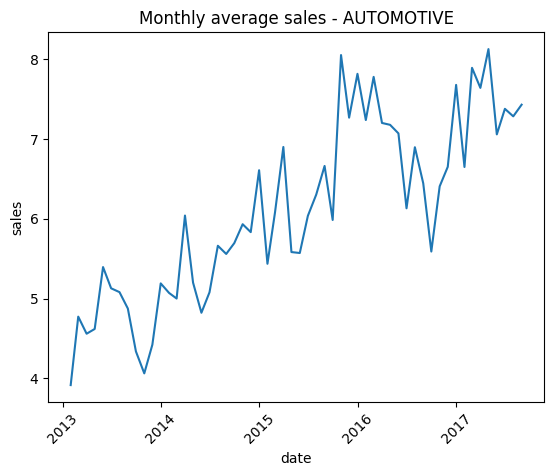

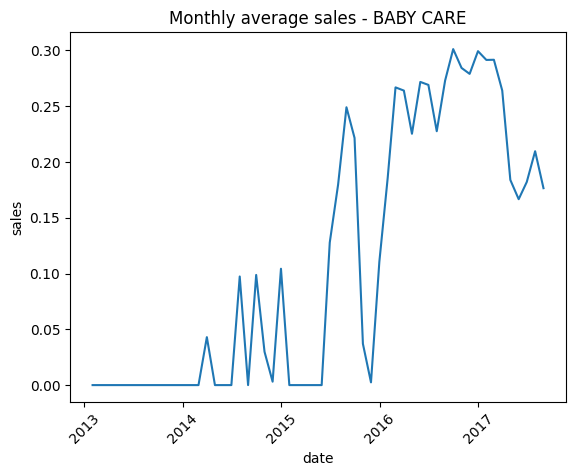

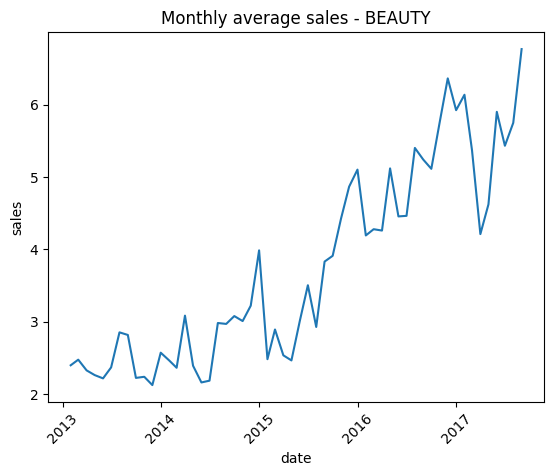

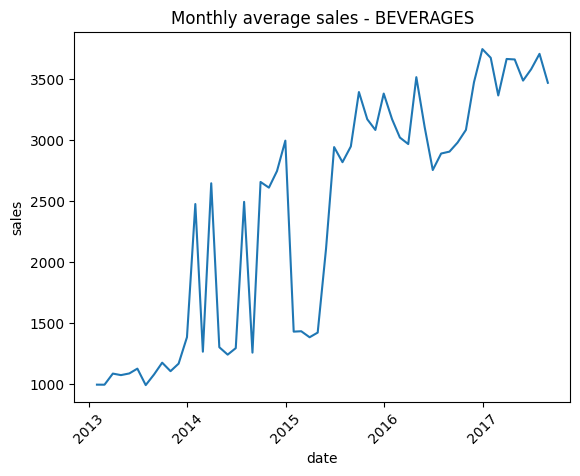

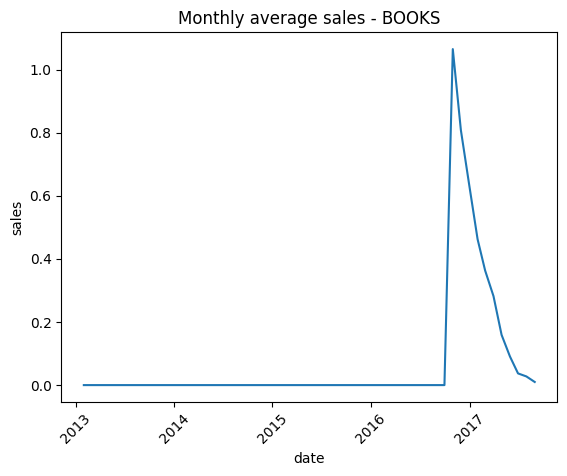

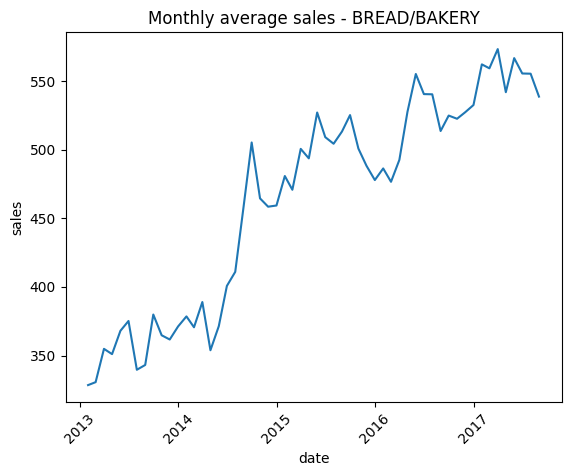

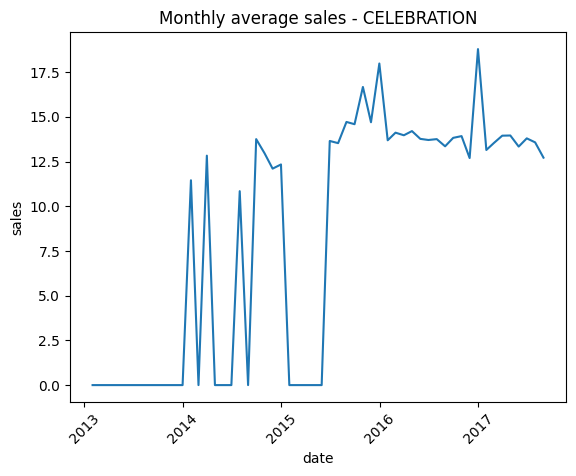

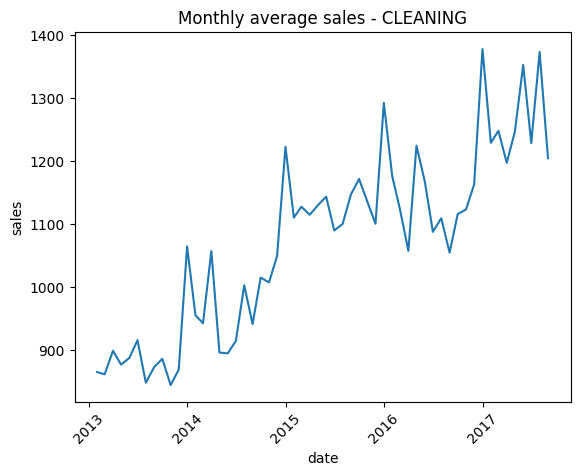

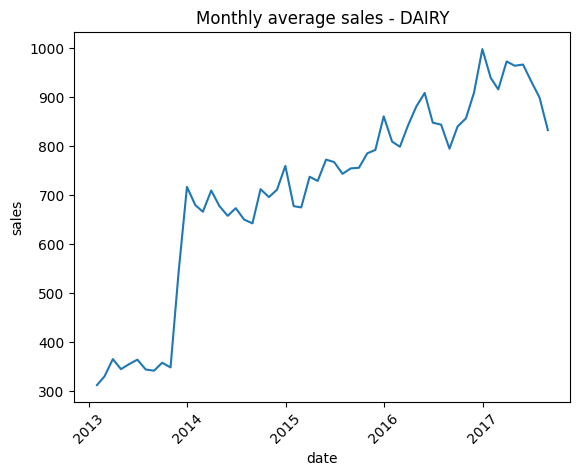

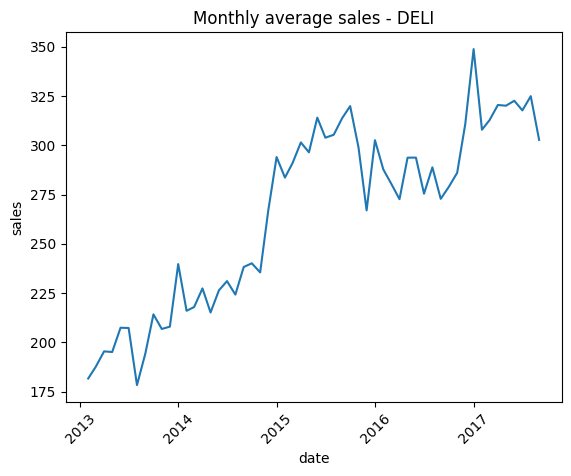

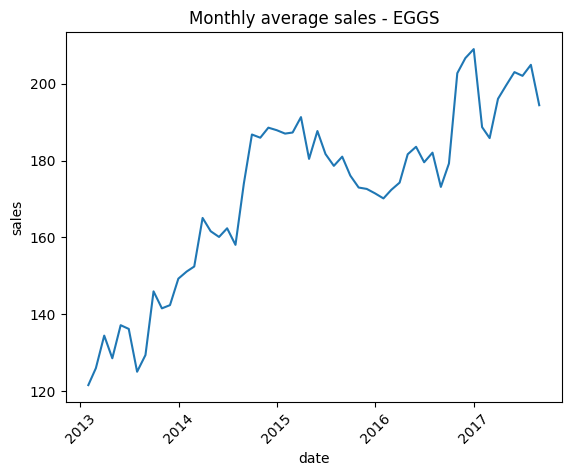

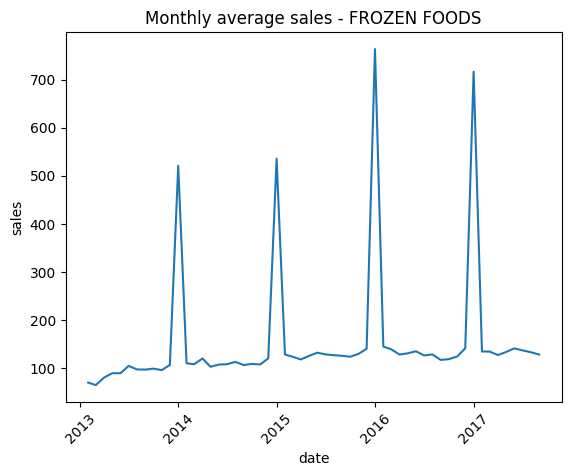

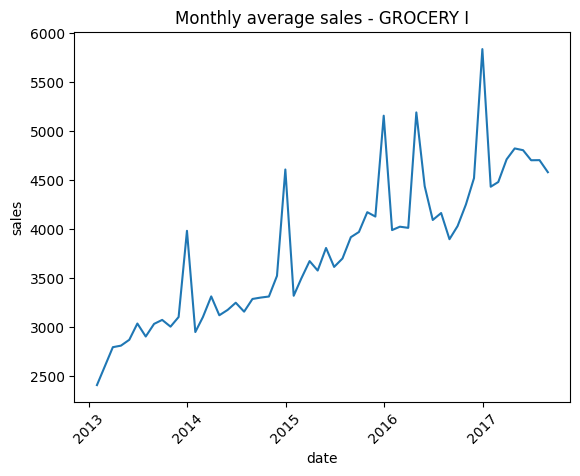

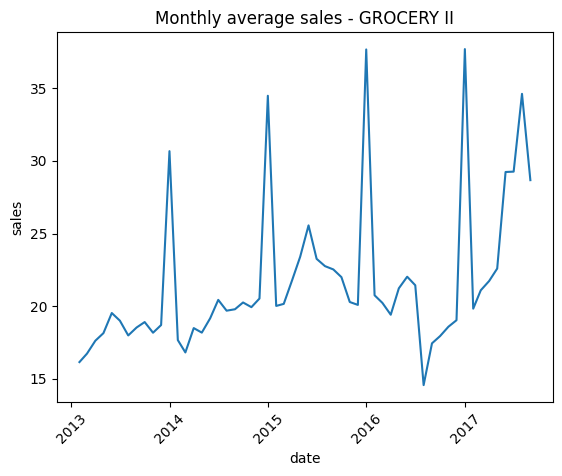

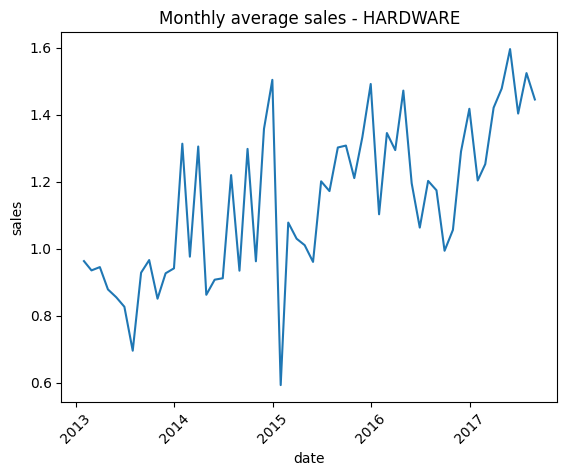

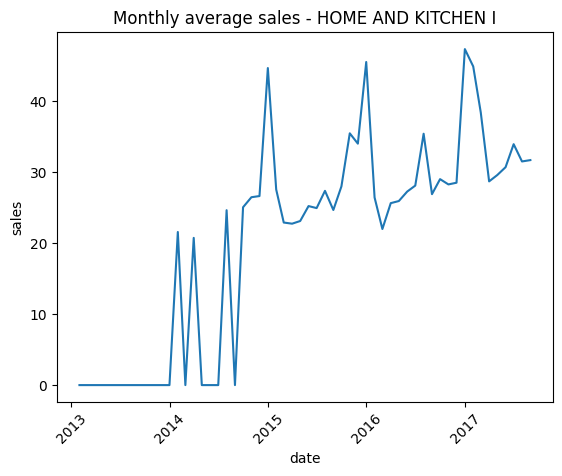

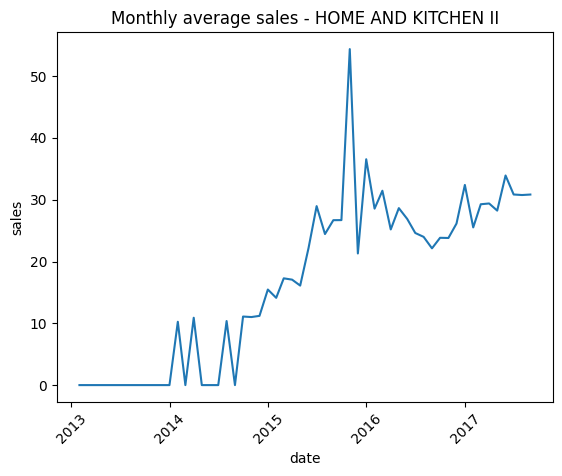

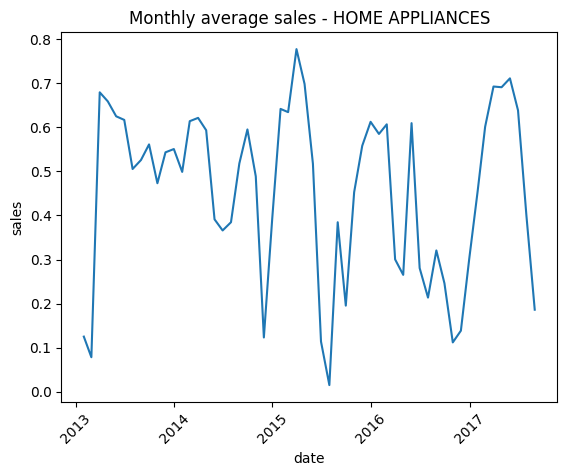

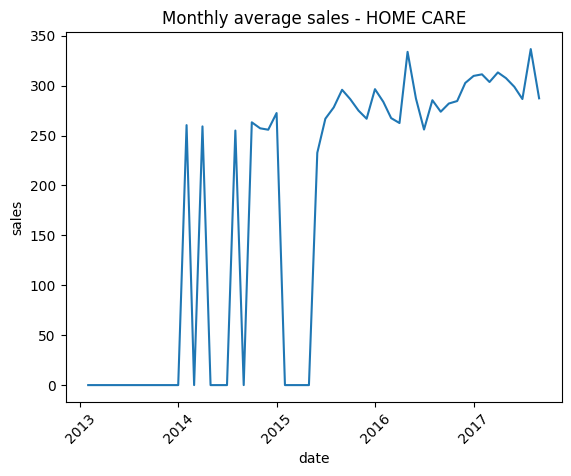

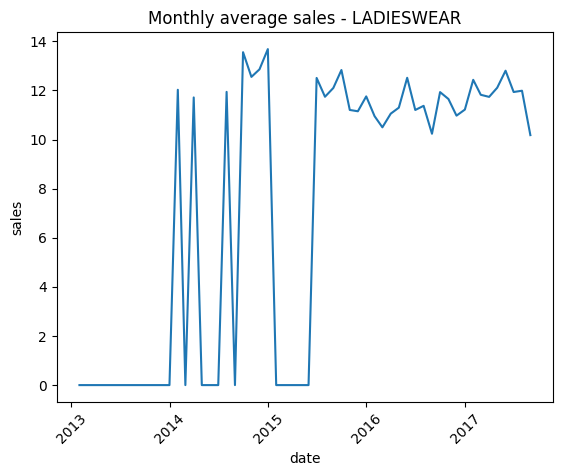

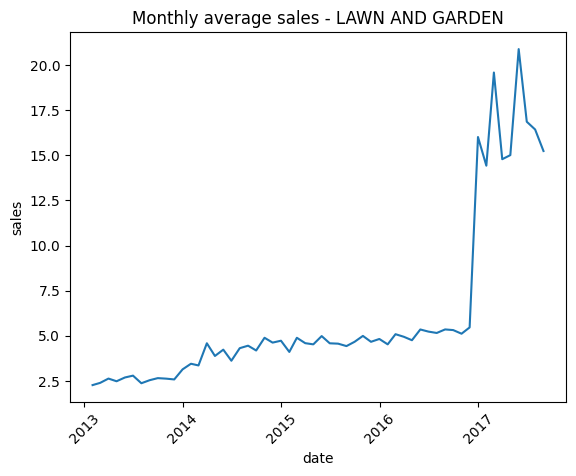

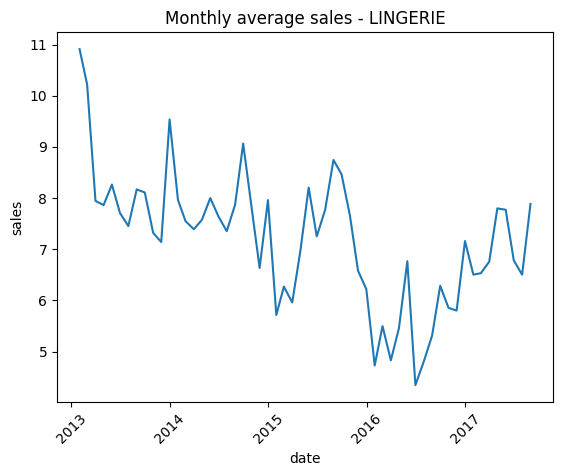

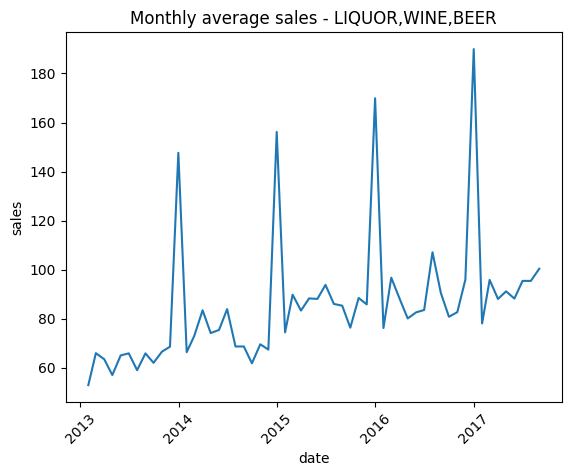

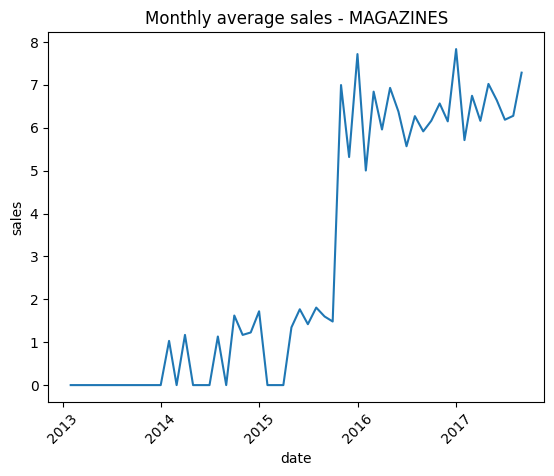

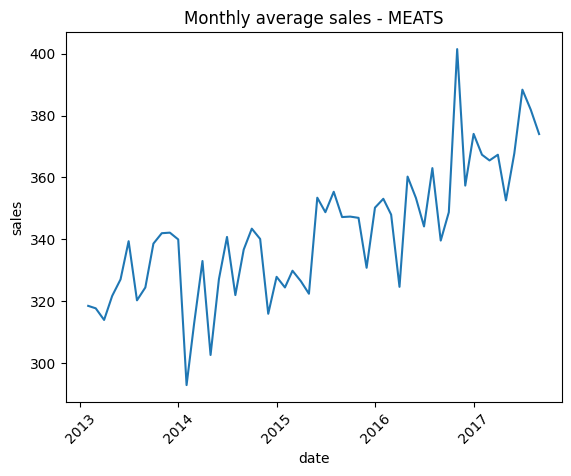

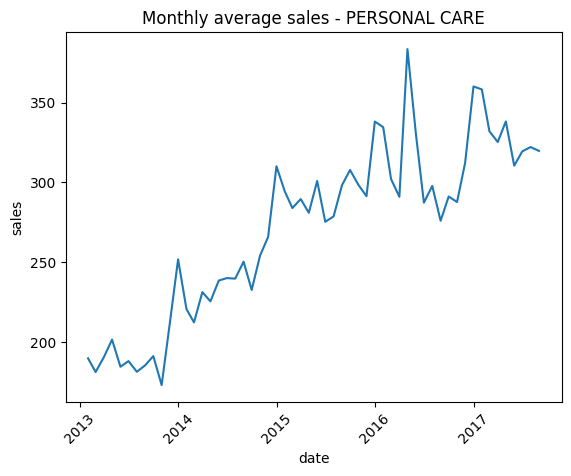

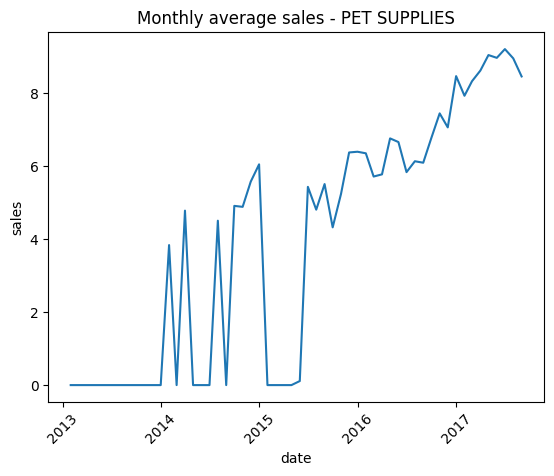

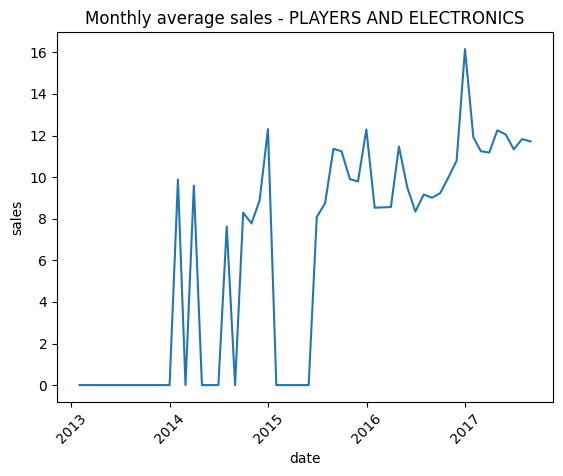

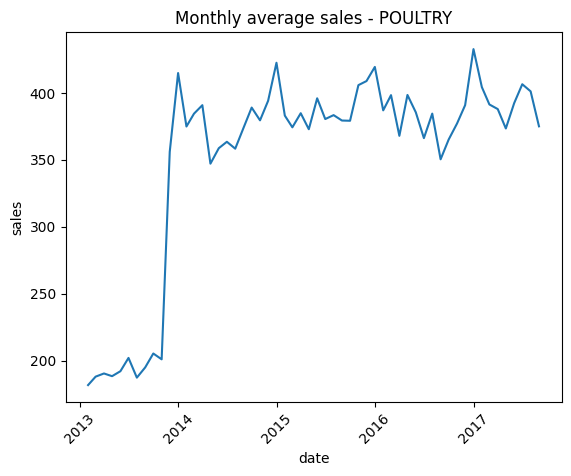

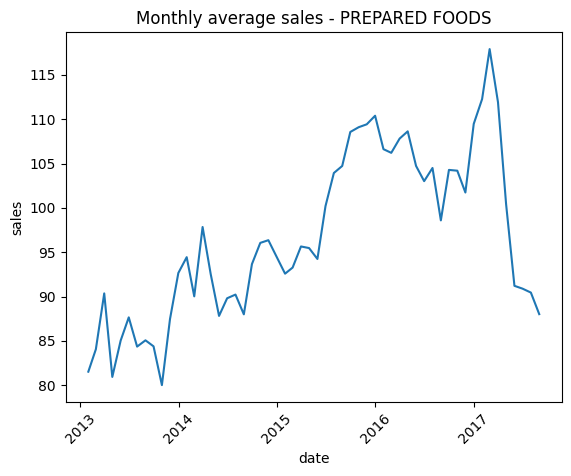

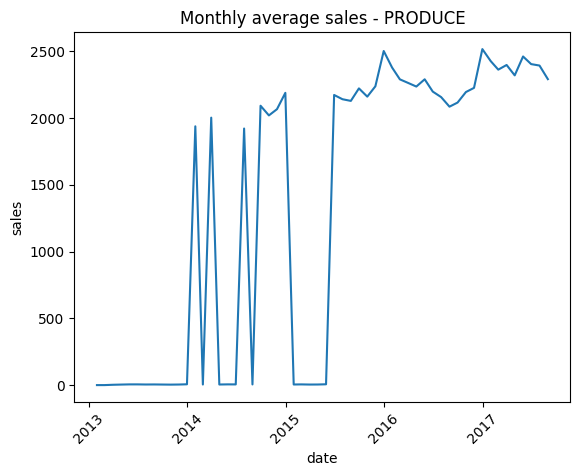

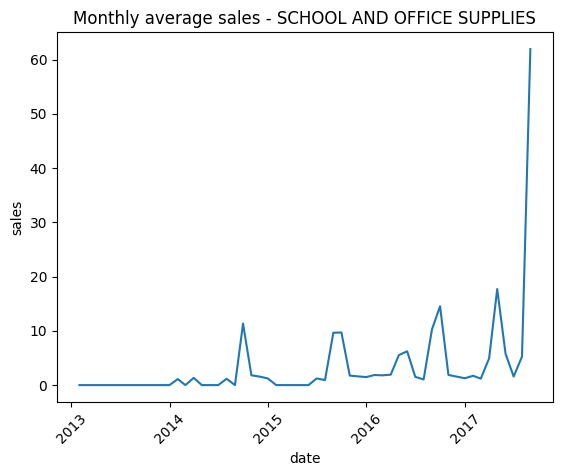

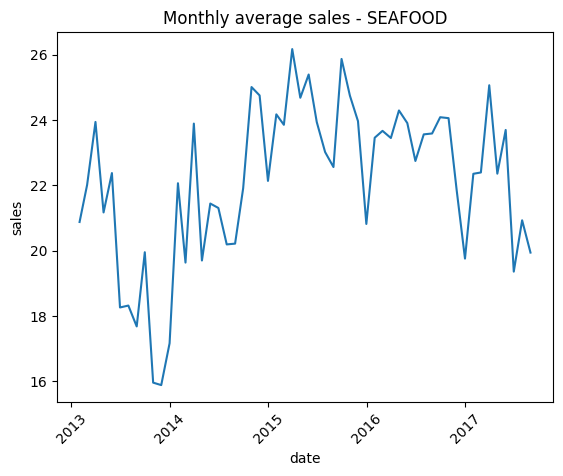

'\nThere are no missing values in the data.\nSpikes can be seen in sales around new year time for the following family of products:\n    1) Celebration\n    2) Cleaning\n    3) Frozen foods\n    4) Groceries\n    5) Home and kitchen\n    6) Home appliances\n    7) Liquor, wine and beer\n'

In [3]:
for family in average_monthly_sales_by_family.index.get_level_values('family').unique():
    sns.lineplot(data = average_monthly_sales_by_family.xs(family, level='family'), x = "date", y = "sales")
    plt.xticks(rotation=45)
    plt.title("Monthly average sales - {}".format(family))
    plt.show()
    
'''
There are no missing values in the data.
Spikes can be seen in sales around new year time for the following family of products:
    1) Celebration
    2) Cleaning
    3) Frozen foods
    4) Groceries
    5) Home and kitchen
    6) Home appliances
    7) Liquor, wine and beer
'''

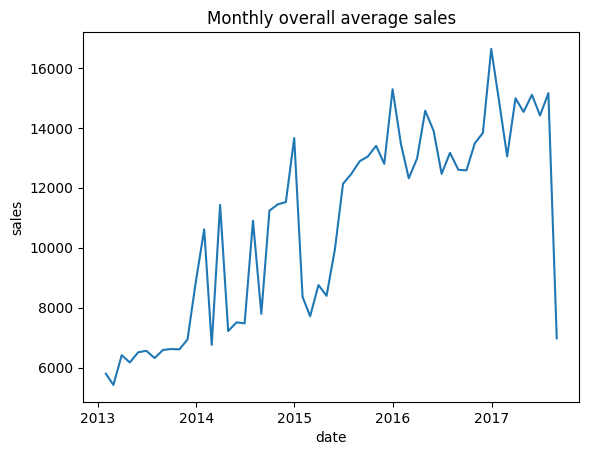

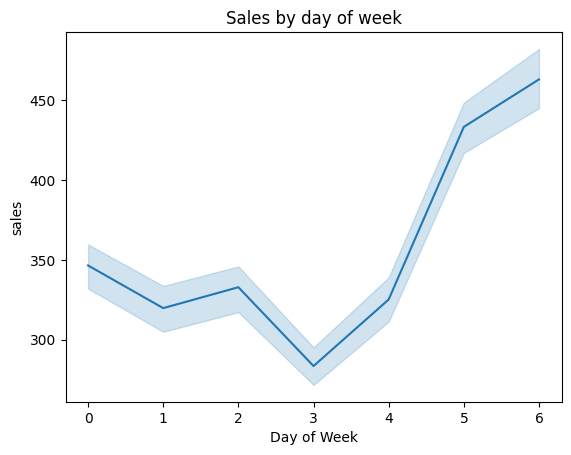

In [4]:
average_sales = train_df.groupby("date").mean()

average_monthly_sales = average_sales.groupby(pd.Grouper(level='date', freq='M')).sum()

sns.lineplot(data = average_monthly_sales, x = "date", y = "sales")
plt.title("Monthly overall average sales")
plt.show()

average_weekly_sales = average_sales.copy()
average_weekly_sales["Week"] = average_weekly_sales.index.isocalendar().week
average_weekly_sales["Day of Week"] = average_weekly_sales.index.weekday

sns.lineplot(data = average_weekly_sales, x = 'Day of Week', y = 'sales')
plt.title("Sales by day of week")
plt.show()

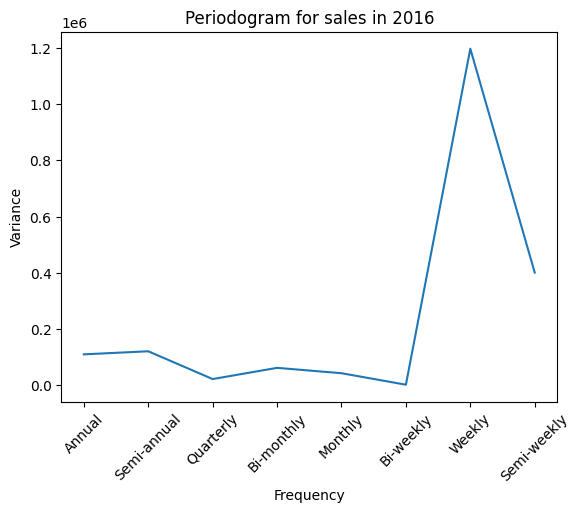

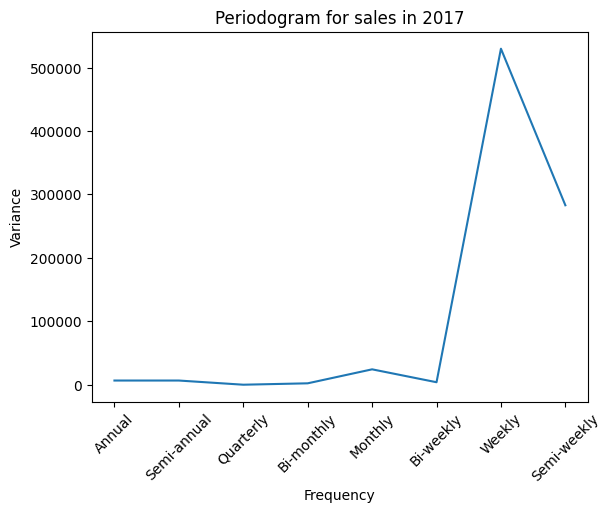

In [5]:
def compute_periodogram_data(average_sales):
    
    frequencies, power = periodogram(average_sales['sales'])
    
    annual = 1 / 365
    semiannual = 1 / (365 / 2)
    quarterly = 1 / (365 / 4)
    bimonthly = 1 / (365 / 6)
    monthly = 1 / (365 / 12)
    biweekly = 1 / 14
    weekly = 1 / 7
    semiweekly = 1 / (7 / 2)
    
    highlight_freqs = [annual, semiannual, quarterly, bimonthly, monthly, biweekly, weekly, semiweekly]
    
    frequency_names = ['Annual', 'Semi-annual', 'Quarterly', 'Bi-monthly', 'Monthly', 'Bi-weekly', 'Weekly', 'Semi-weekly']
    
    indices = [np.argmin(np.abs(frequencies - freq)) for freq in highlight_freqs]
    filtered_frequencies = frequencies[indices]
    filtered_power = power[indices]
    
    periodogram_df = pd.DataFrame(columns = ['Frequency','Frequency Values','Variance'])
    
    periodogram_df['Frequency'] = frequency_names
    periodogram_df['Frequency Values'] = filtered_frequencies
    periodogram_df['Variance'] = filtered_power
    
    return periodogram_df

sns.lineplot(data = compute_periodogram_data(average_sales.loc['2016']),
             x = 'Frequency',
             y = 'Variance')
plt.xticks(rotation=45)
plt.title("Periodogram for sales in 2016")
plt.show()

sns.lineplot(data = compute_periodogram_data(average_sales.loc['2017']),
             x = 'Frequency',
             y = 'Variance')
plt.xticks(rotation=45)
plt.title("Periodogram for sales in 2017")
plt.show()

In [6]:
'''
The periodogram for sales and the average monthly sales plot show a strong weekly trend.
For predicting sales from Aug 16 - Aug 31,2017 using linear regression, sales data from 
Jan 1, 2016 to Aug 15, 2017 will be used.
'''

X = average_weekly_sales.loc['2016':'2017'].copy()

X.index = X.index.to_period('D')

y = average_sales.loc['2016':'2017'].copy()

y.index = y.index.to_period('D')

fourier = CalendarFourier(freq = 'M', order = 4)
dp = DeterministicProcess(index=y.index,
                          constant=True,
                          order=1,
                          seasonal = True,
                          additional_terms=[fourier],
                          drop=True)

X = dp.in_sample()

model = LinearRegression().fit(X, y)

y_pred = pd.DataFrame(model.predict(X).squeeze(),index=X.index,columns=['Fitted'])

print("\nBelow is the linear regression model:\n")
print("Intercept:", model.intercept_[0])

coefficients = pd.Series(list(model.coef_[0]), index=list(X.columns))
print("Coefficients:")
print(coefficients)

print("\nTraining R2 of the linear regression model that predicts average weekly sales: {}".format(r2_score(y, y_pred)))


Below is the linear regression model:

Intercept: 436.1814106570357
Coefficients:
const              0.000000
trend              0.121937
s(2,7)            80.876709
s(3,7)            61.108019
s(4,7)           -43.658763
s(5,7)           -51.649869
s(6,7)           -71.367341
s(7,7)           -81.421825
sin(1,freq=ME)     8.264379
cos(1,freq=ME)    18.569573
sin(2,freq=ME)    25.723695
cos(2,freq=ME)    18.590259
sin(3,freq=ME)     7.616853
cos(3,freq=ME)    10.555000
sin(4,freq=ME)     8.682680
cos(4,freq=ME)     2.757164
dtype: float64

Training R2 of the linear regression model that predicts average weekly sales: 0.4569891535350501


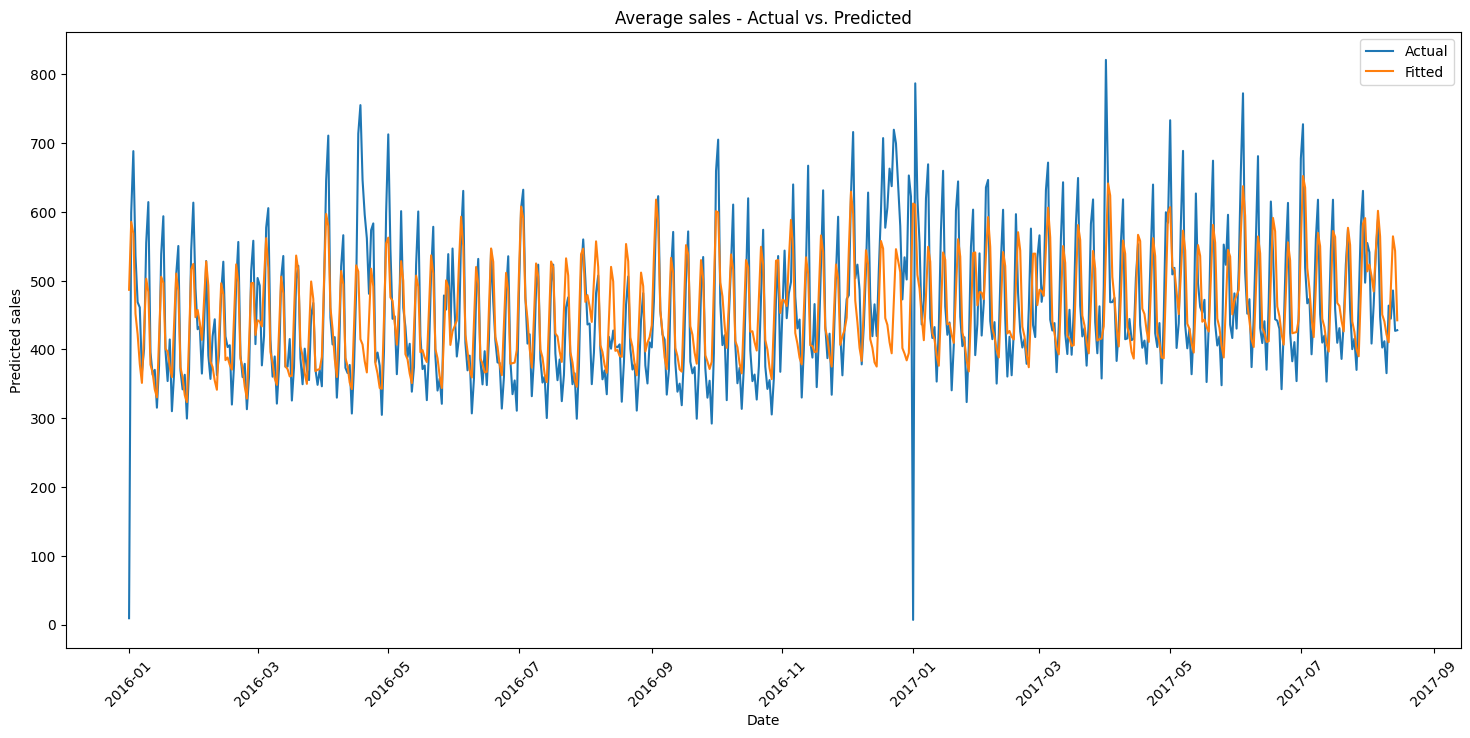

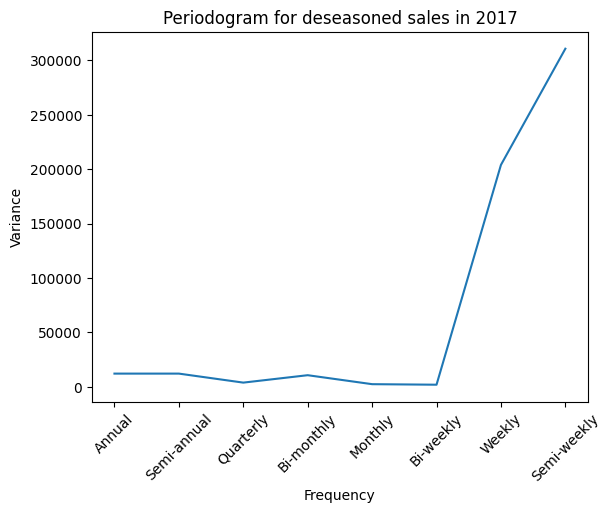

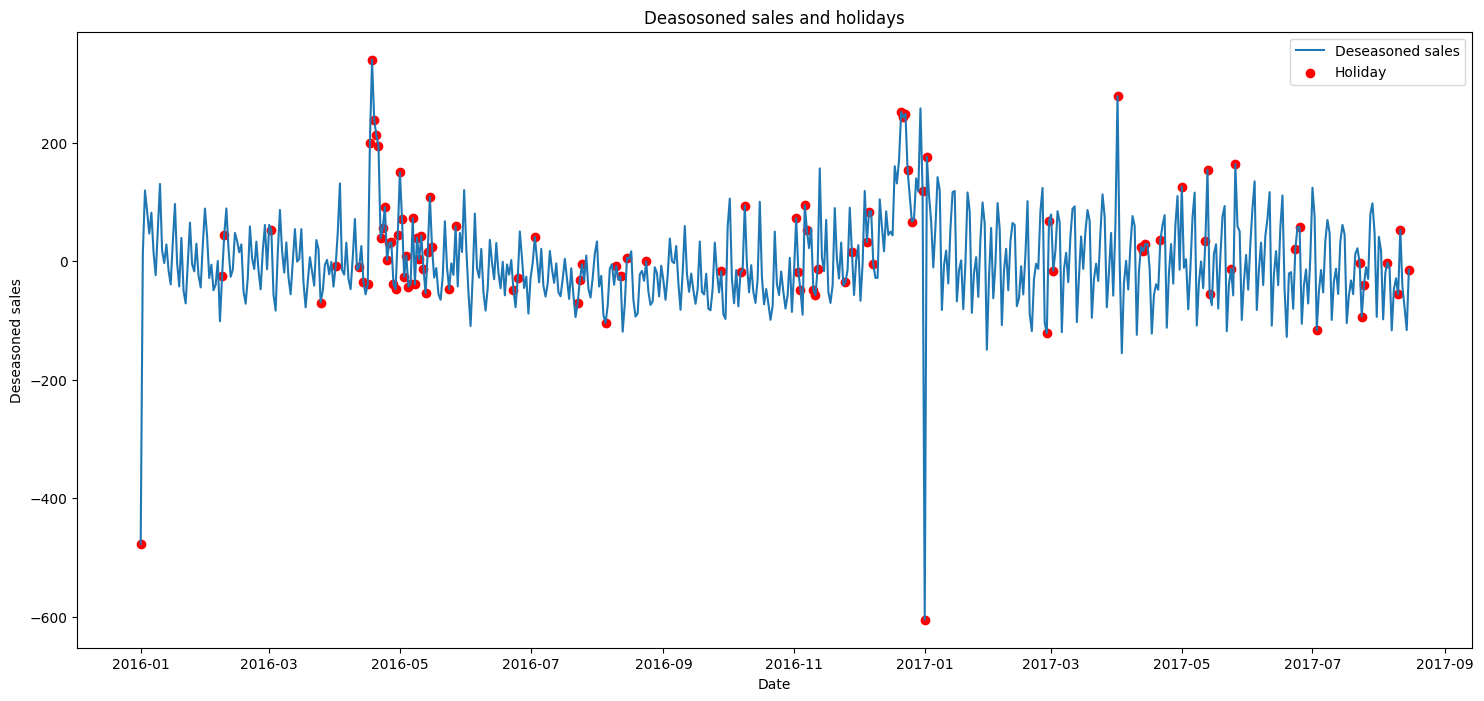

In [7]:
prediction_plot_df = pd.DataFrame(columns=['Actual', 'Fitted'])
prediction_plot_df['Actual'] = y.copy()
prediction_plot_df['Fitted'] = y_pred['Fitted'].copy()

prediction_plot_df.index = prediction_plot_df.index.to_timestamp()

plt.figure(figsize=(18, 8))
sns.lineplot(data=prediction_plot_df, x = "date", y = "Actual", label = "Actual", markers = True)
sns.lineplot(data=prediction_plot_df, x = "date", y = "Fitted", label = "Fitted", markers = True)
plt.xlabel('Date')
plt.ylabel('Predicted sales')
plt.xticks(rotation=45)
plt.title('Average sales - Actual vs. Predicted')
plt.legend()
plt.show()

y_deseason = pd.DataFrame({"sales":y['sales'] - y_pred['Fitted']} )

common_holiday_index = holiday_event_df_without_duplicates.index.intersection(y_deseason.index)

y_deseason.loc[common_holiday_index, 'description'] = holiday_event_df_without_duplicates.loc[common_holiday_index, 'description']

y_deseason_periodogram = y_deseason.copy()

y_deseason_periodogram.index = y_deseason_periodogram.index.to_timestamp()

sns.lineplot(data = compute_periodogram_data(y_deseason_periodogram.loc['2017']),
             x = 'Frequency',
             y = 'Variance')
plt.xticks(rotation=45)
plt.title("Periodogram for deseasoned sales in 2017")
plt.show()

plt.figure(figsize=(18, 8))
plt.plot(y_deseason_periodogram.index, y_deseason_periodogram['sales'], label='Deseasoned sales')
highlight = y_deseason_periodogram['description'].notna()
plt.scatter(y_deseason_periodogram.index[highlight], y_deseason_periodogram['sales'][highlight], color='red', label='Holiday')
plt.xlabel('Date')
plt.ylabel('Deseasoned sales')
plt.legend()
plt.title('Deasosoned sales and holidays')
plt.show()


Training R2 of the linear regression model that predicts average weekly sales after adding holiday and newyear indicator: 0.5743852887794747


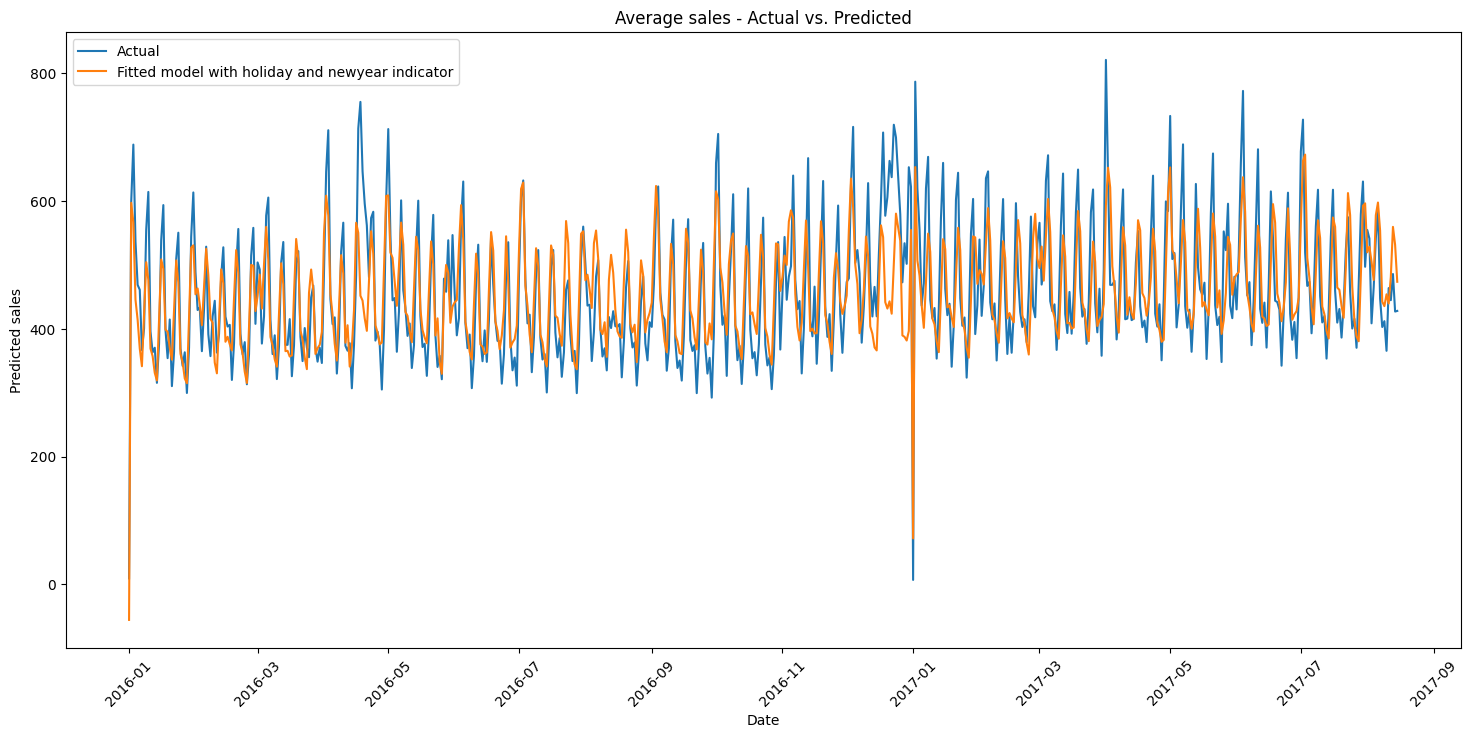

In [8]:
#The variance in the deseasoned sales periodogram is less compared to the periodogram of actual sales. Linear regression did capture some of the variation in sales. 

#Adding holidys and newyear indicator could improve average sales prediction.

X_lr = X.copy()

X_lr['holiday'] = X_lr.index.to_series().isin(holiday_event_df.index)

NewYear = pd.DataFrame({'NewYear': (X_lr.index.dayofyear == 1)}, index=X_lr.index)

X_lr = pd.concat([X_lr, NewYear], axis=1)

model = LinearRegression().fit(X_lr, y)

y_pred1 = pd.DataFrame(model.predict(X_lr).squeeze(),index=X_lr.index,columns=['Fitted'])

print("\nTraining R2 of the linear regression model that predicts average weekly sales after adding holiday and newyear indicator: {}".format(r2_score(y, y_pred1)))

prediction_plot_df.index = prediction_plot_df.index.to_period('D')

prediction_plot_df['Fitted_1'] = y_pred1['Fitted'].copy()

prediction_plot_df.index = prediction_plot_df.index.to_timestamp()

plt.figure(figsize=(18, 8))
sns.lineplot(data=prediction_plot_df, x = "date", y = "Actual", label = "Actual", markers = True)
sns.lineplot(data=prediction_plot_df, x = "date", y = "Fitted_1", label = "Fitted model with holiday and newyear indicator", markers = True)
plt.xlabel('Date')
plt.ylabel('Predicted sales')
plt.xticks(rotation=45)
plt.title('Average sales - Actual vs. Predicted')
plt.legend()
plt.show()

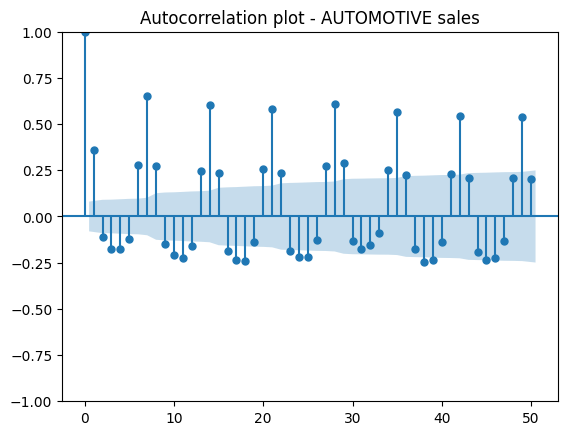

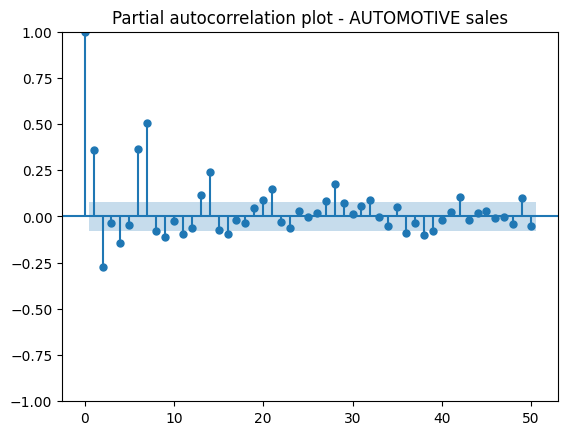

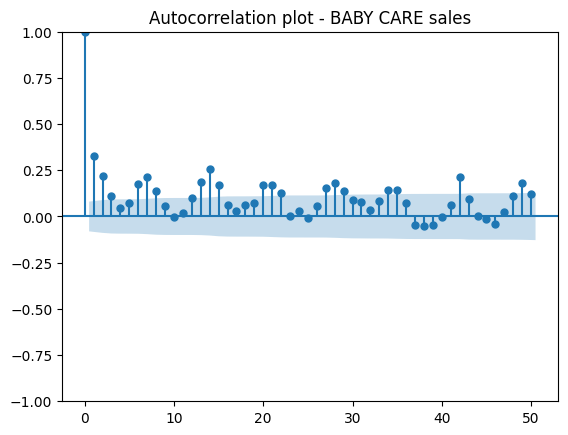

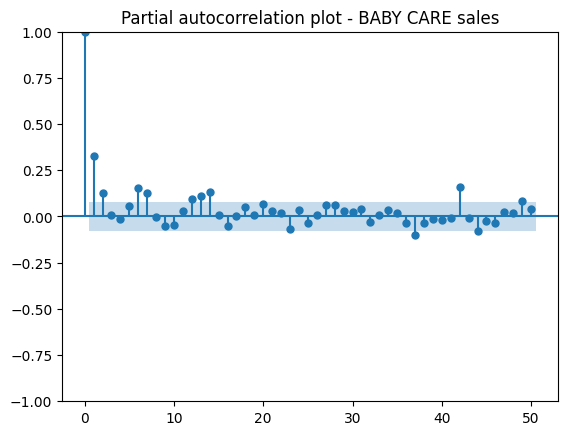

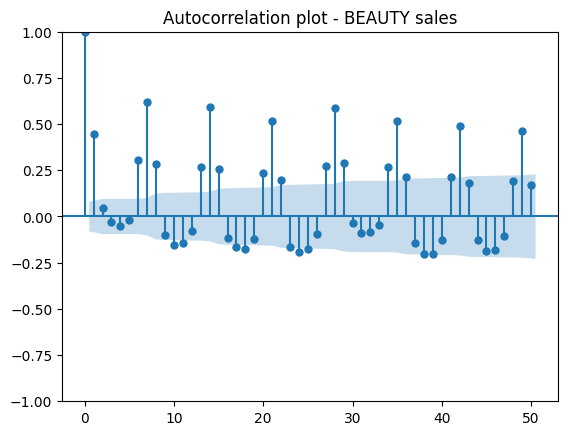

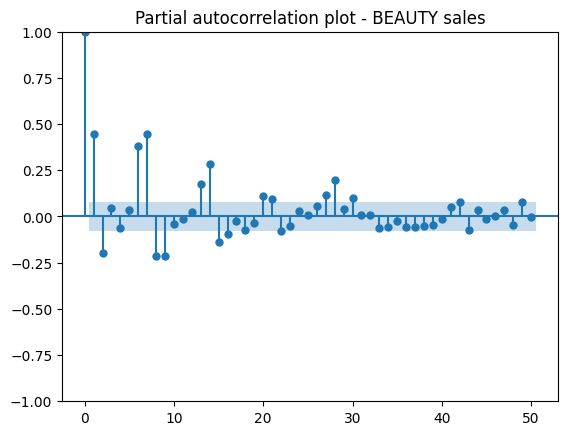

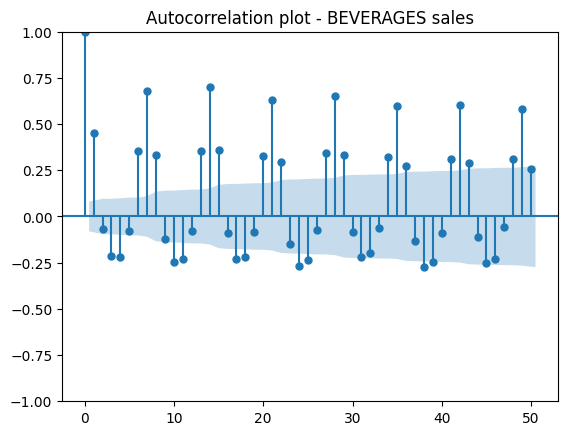

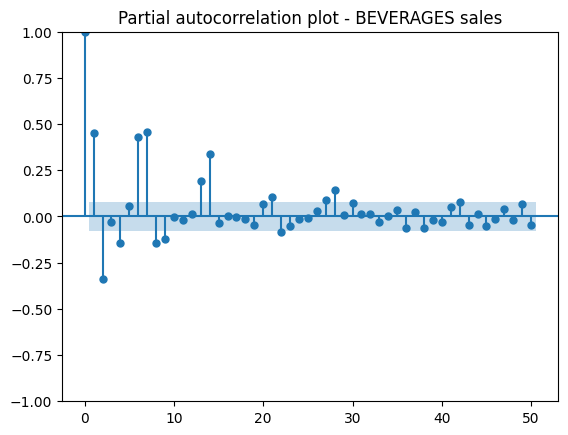

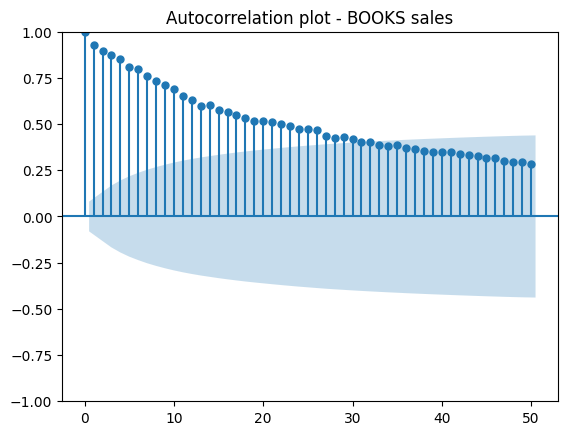

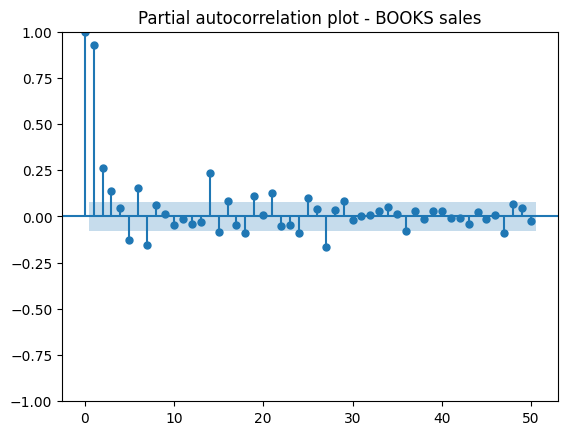

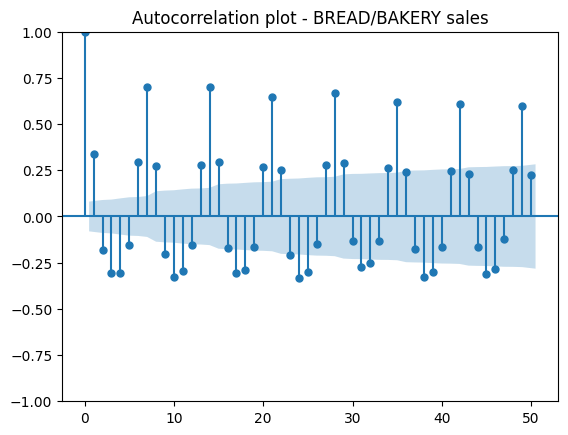

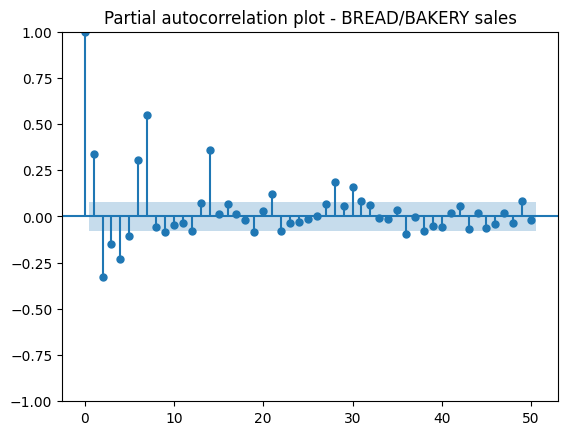

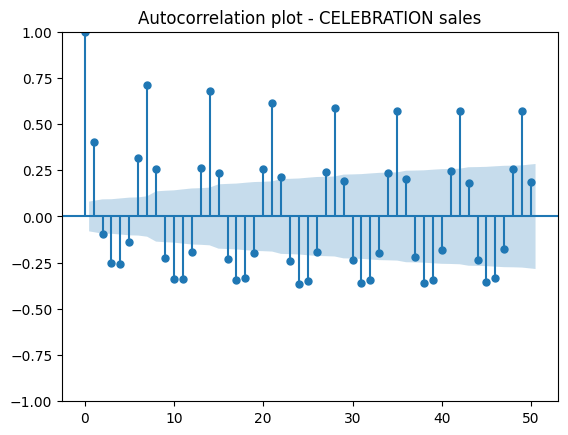

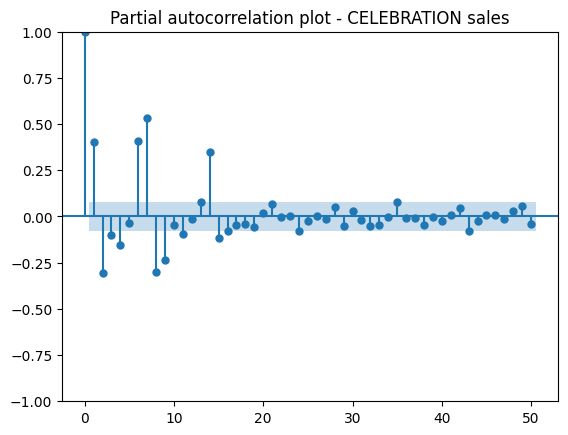

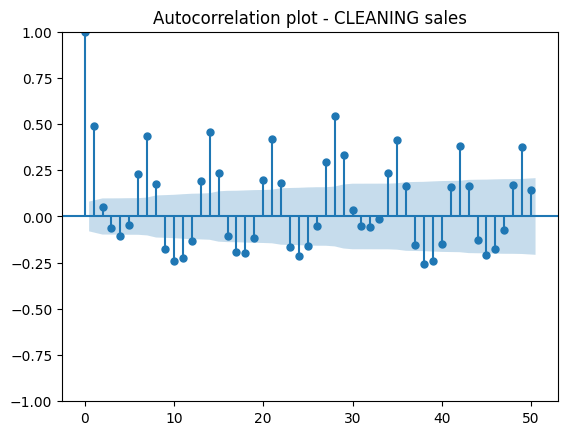

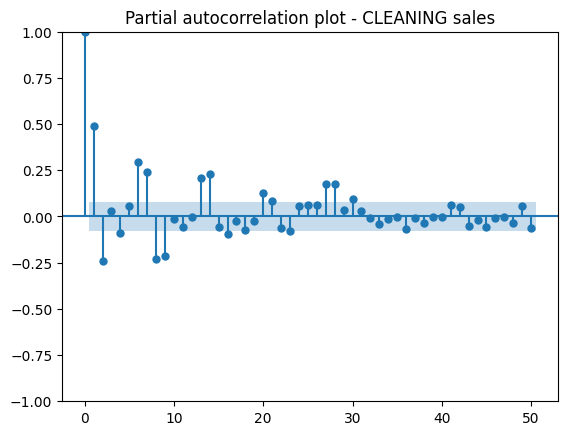

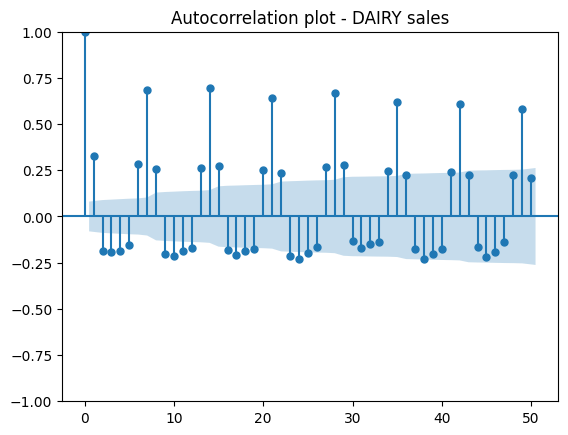

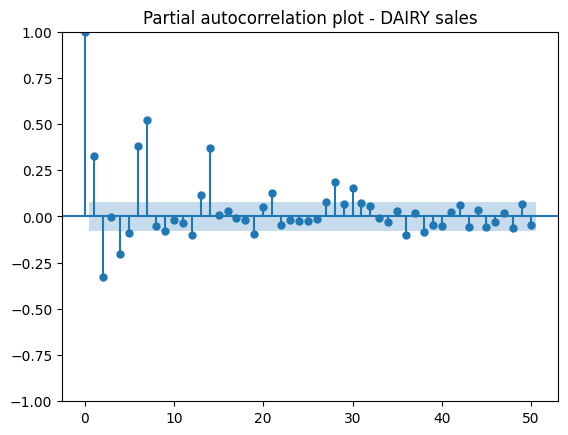

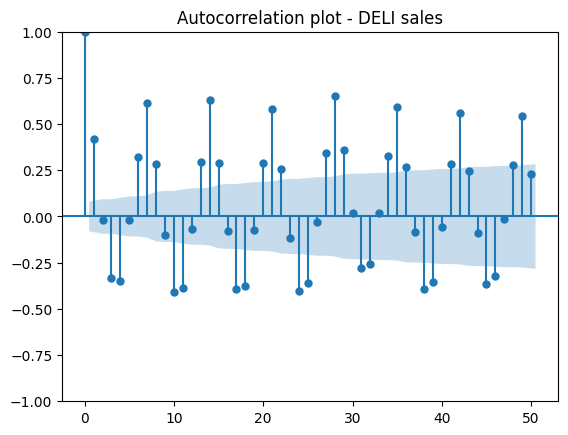

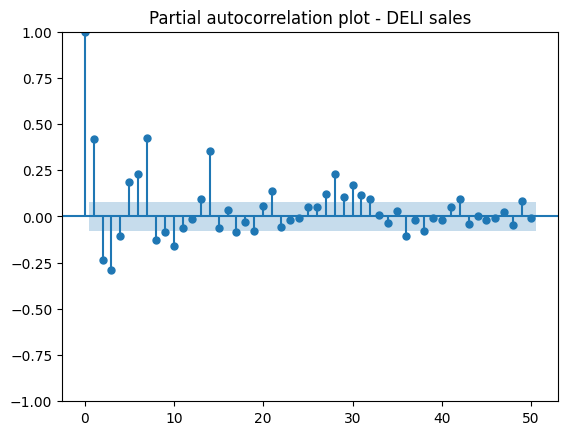

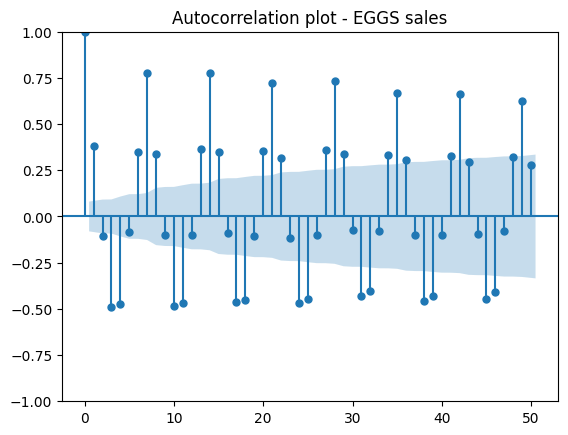

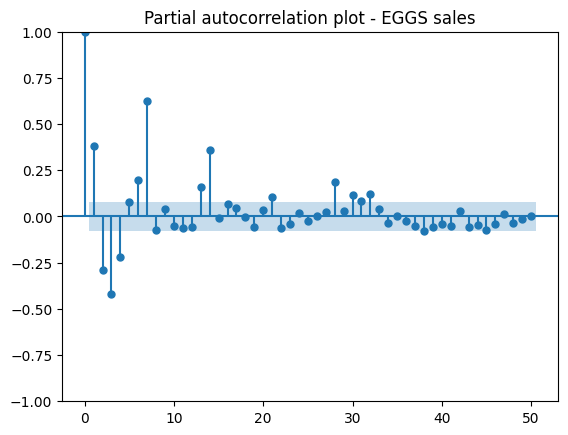

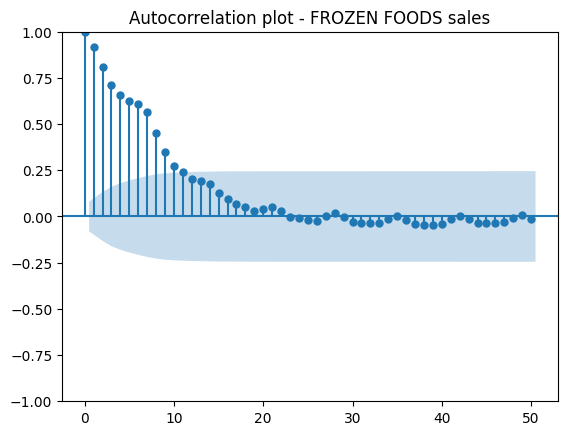

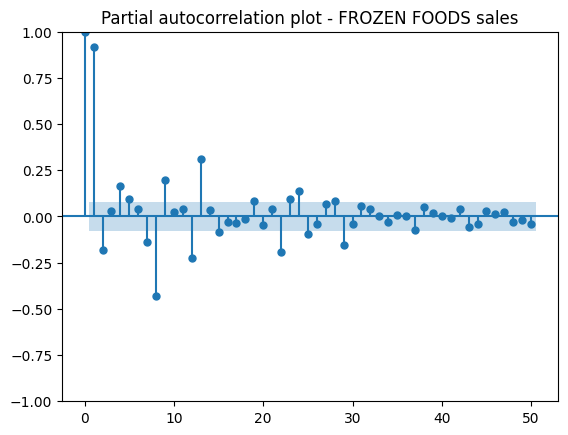

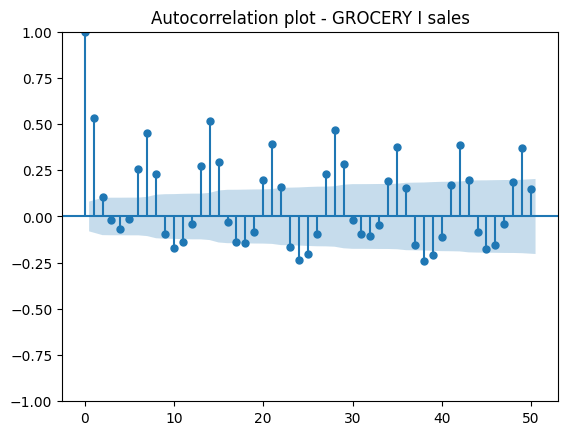

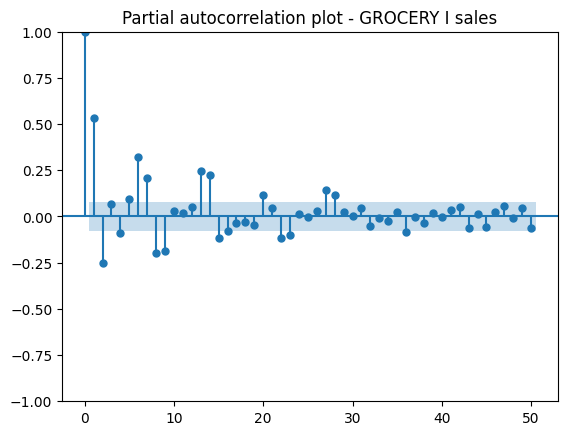

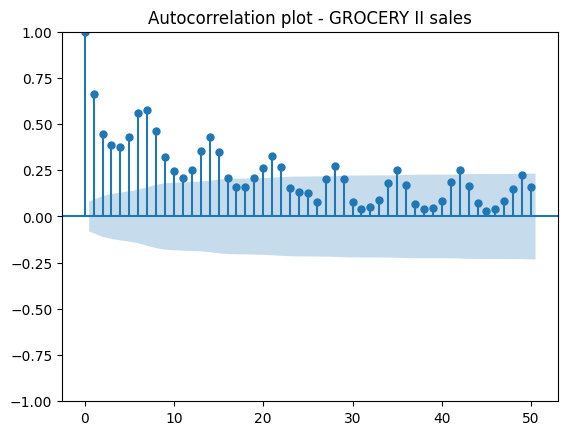

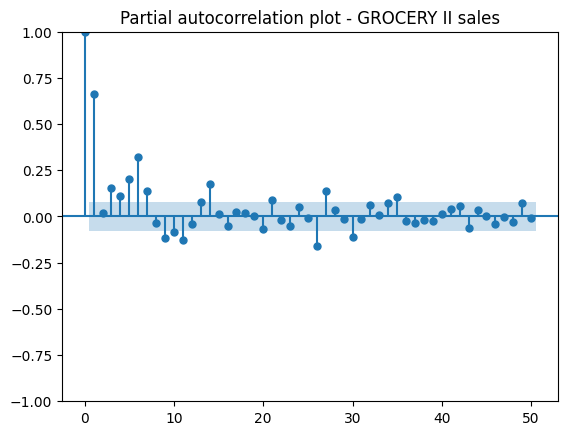

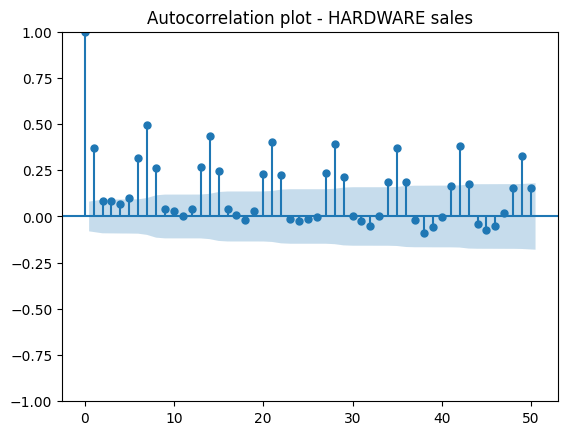

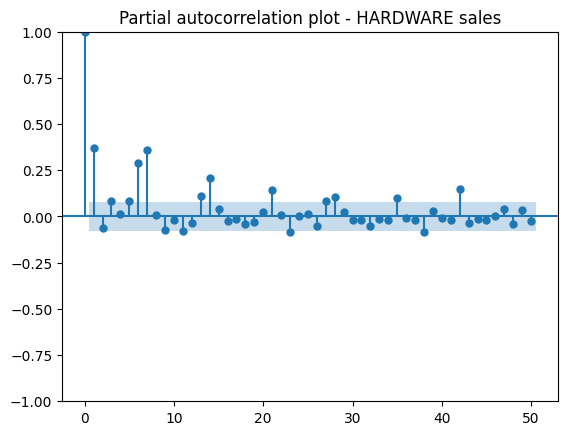

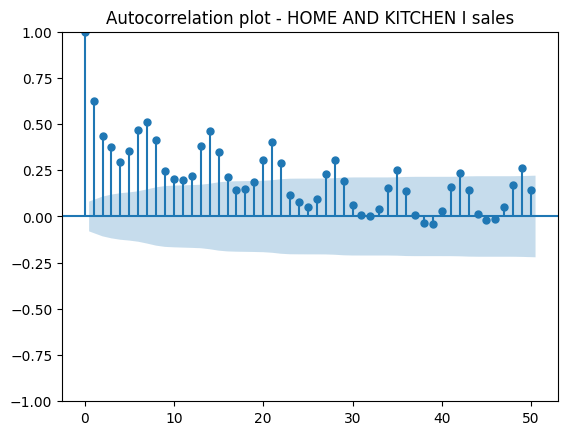

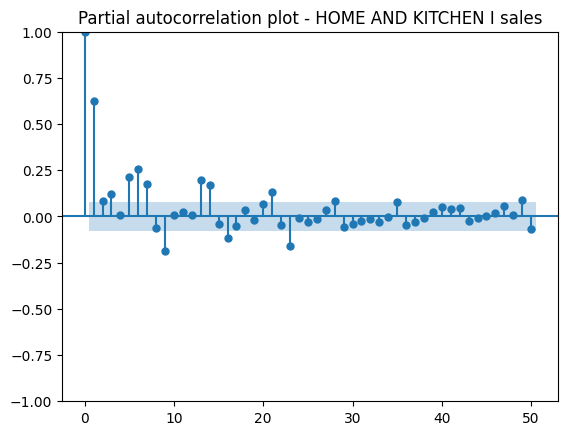

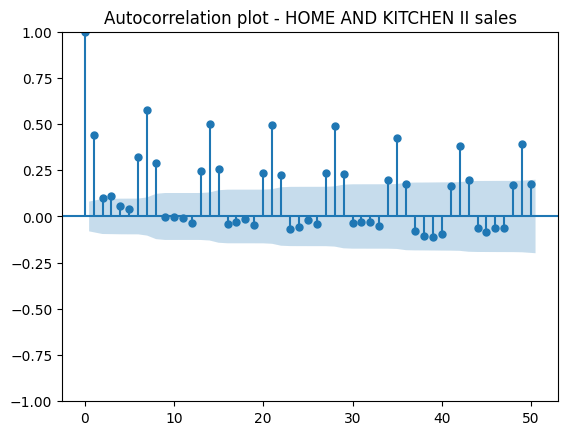

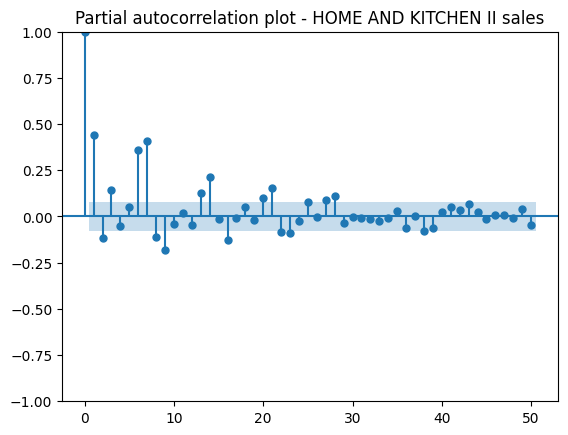

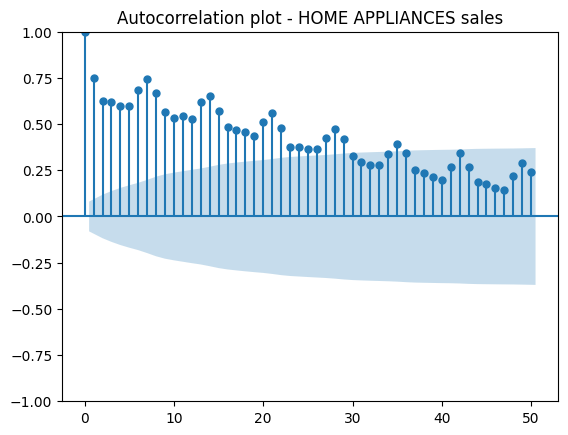

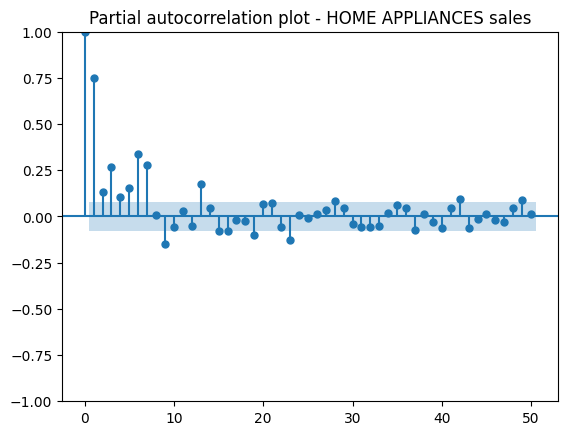

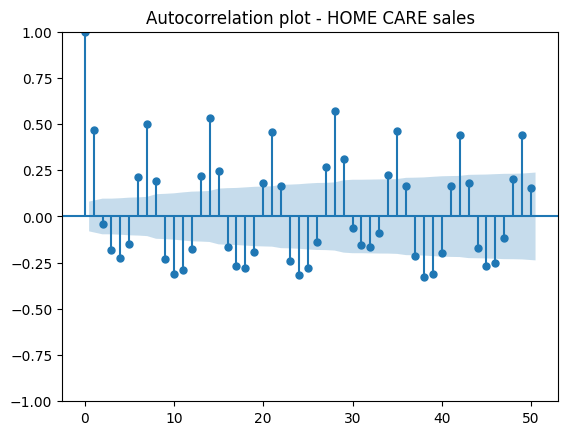

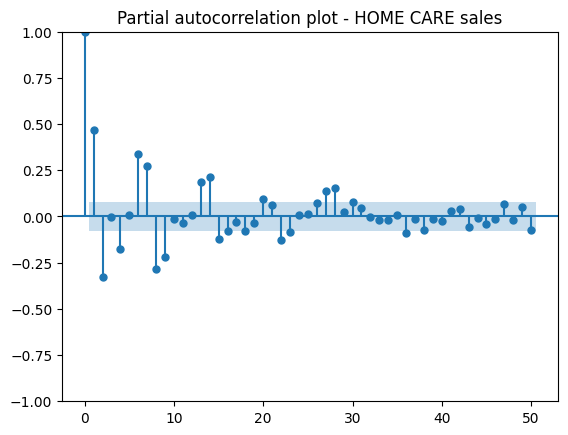

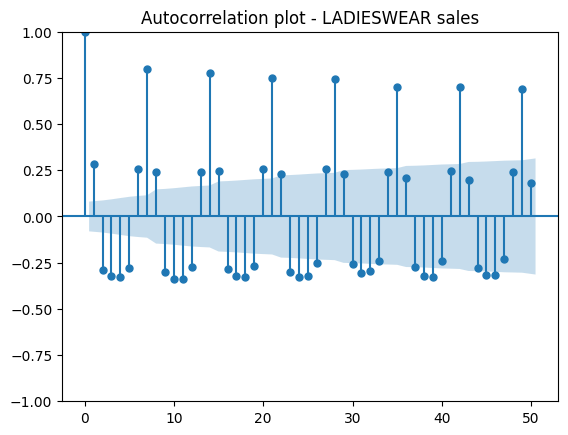

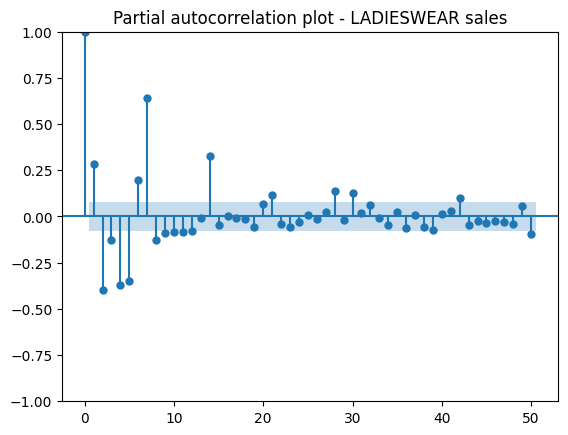

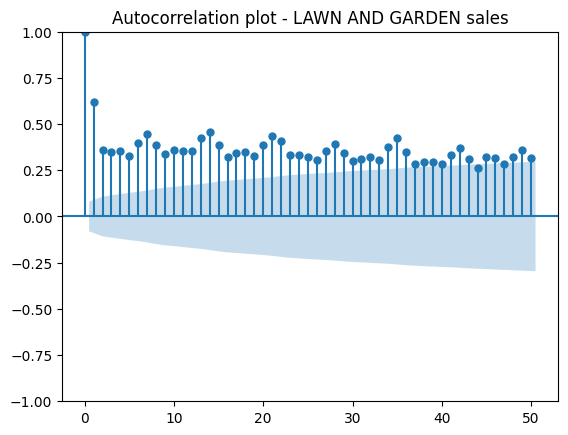

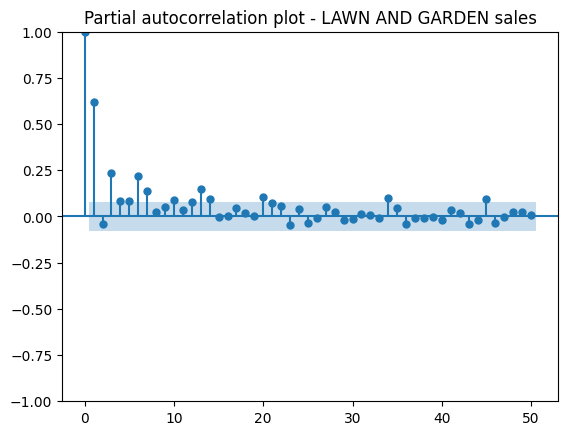

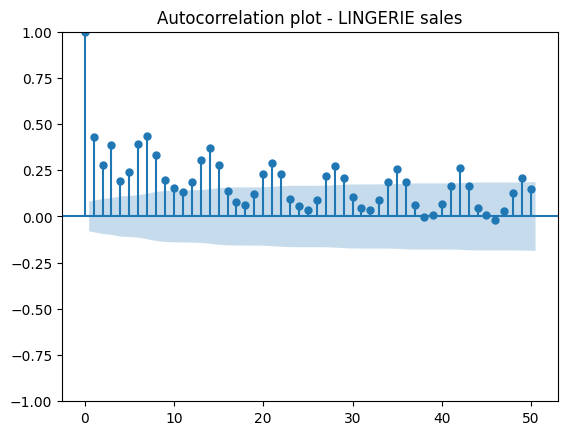

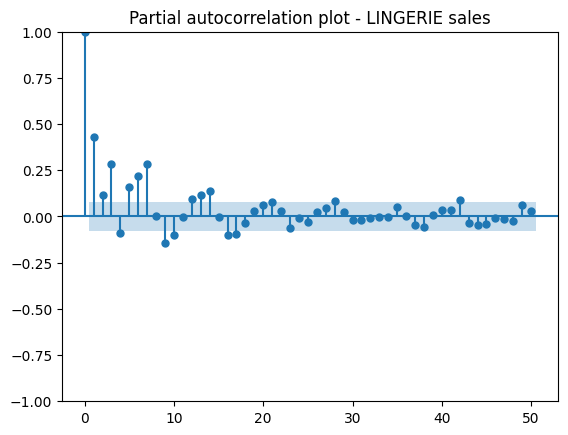

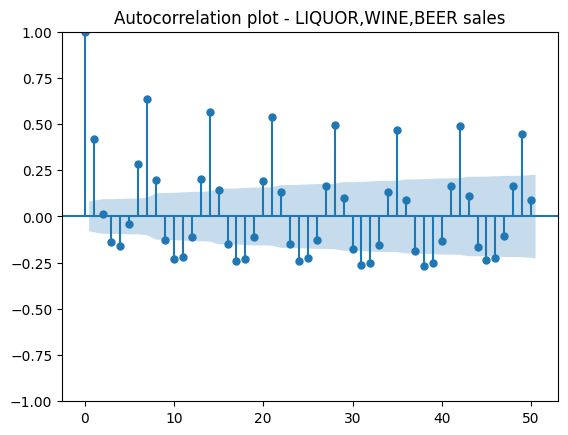

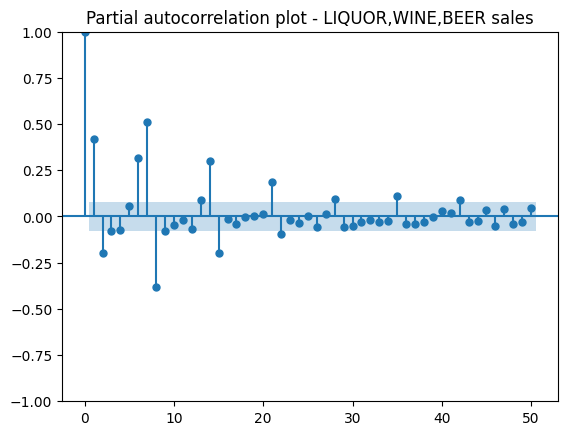

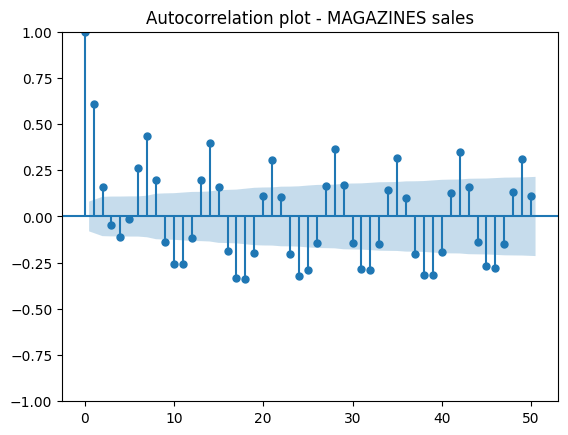

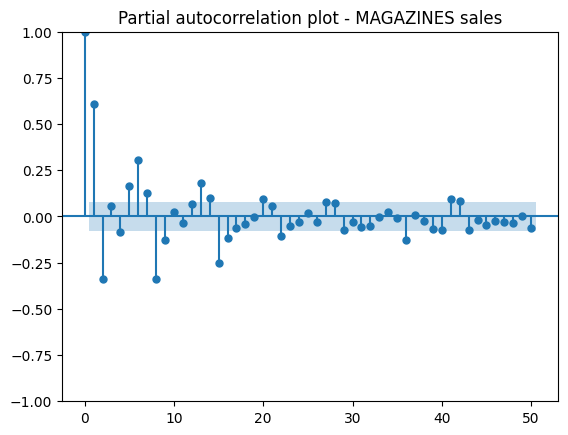

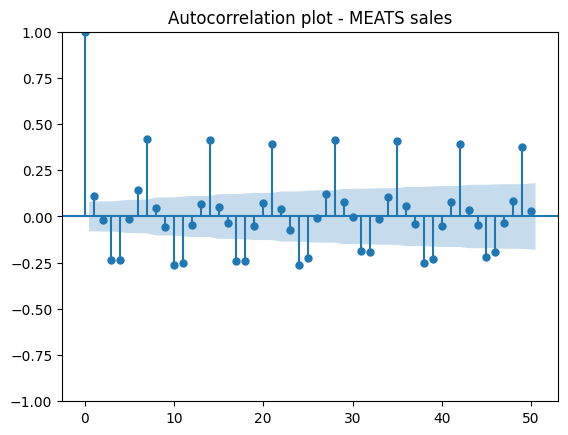

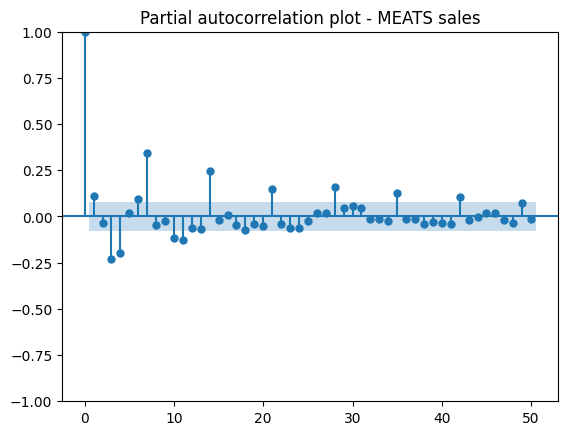

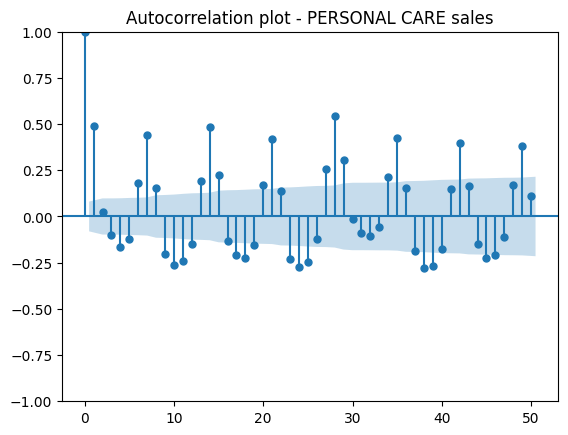

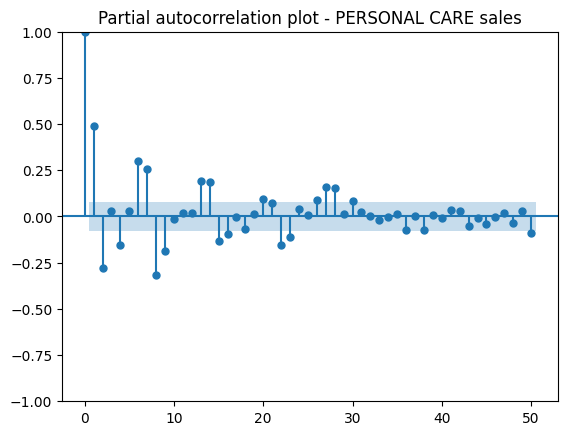

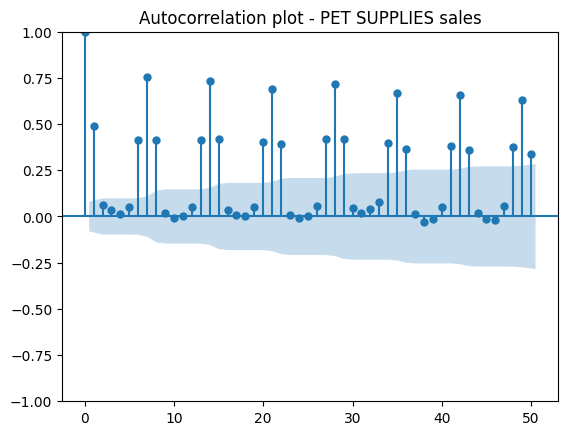

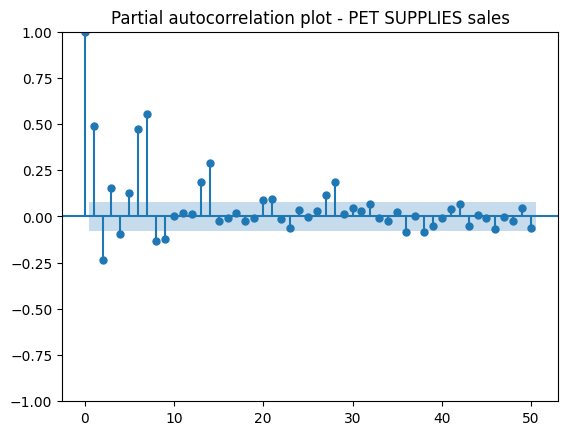

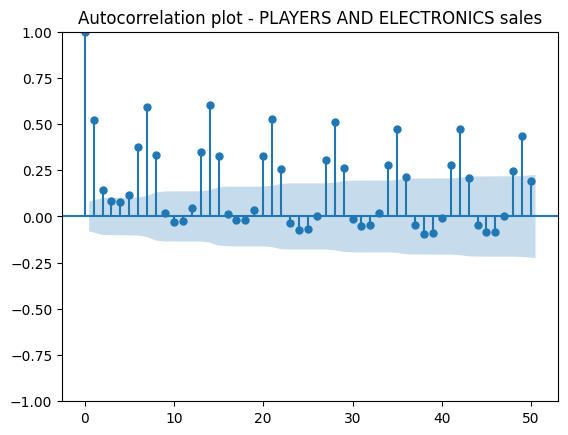

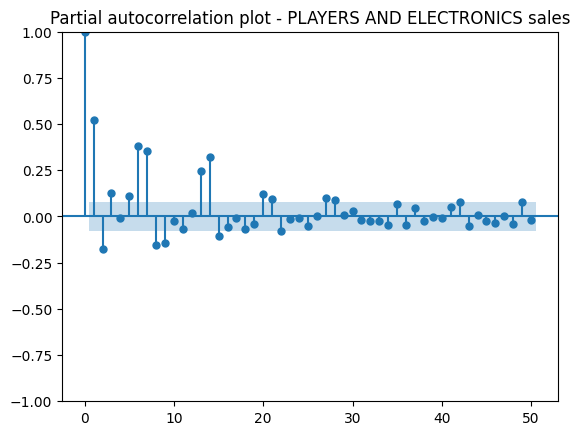

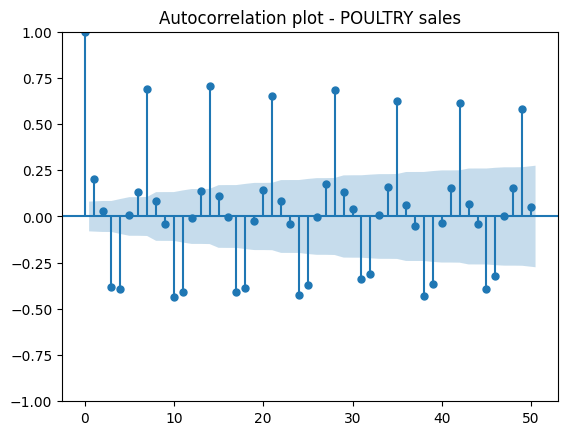

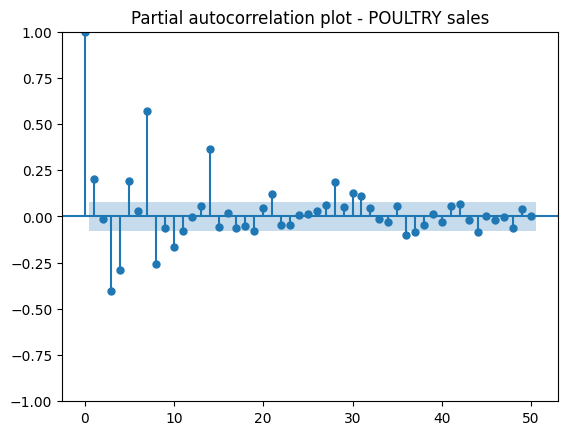

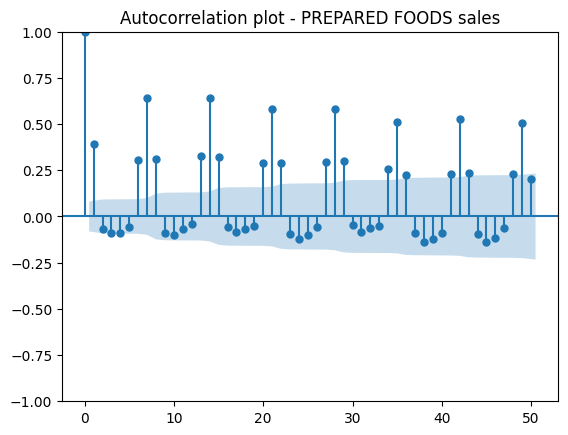

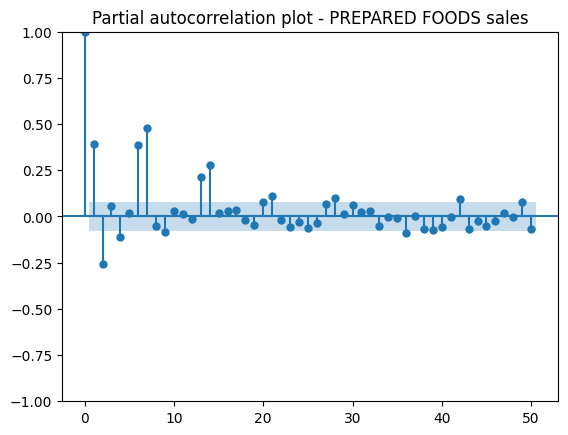

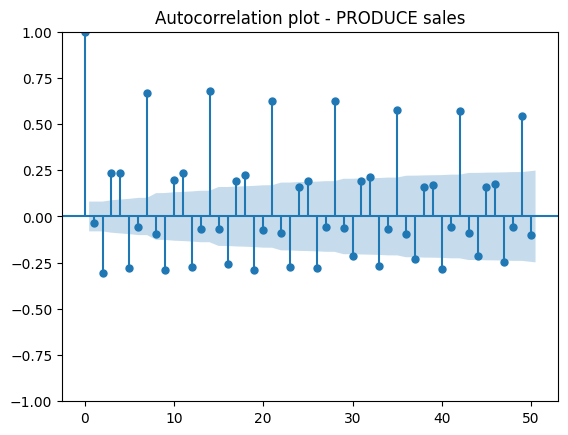

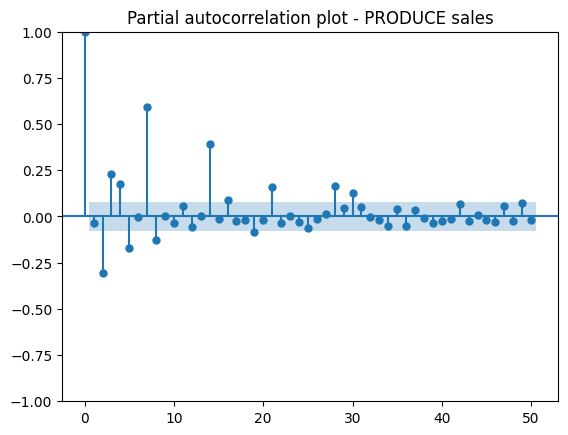

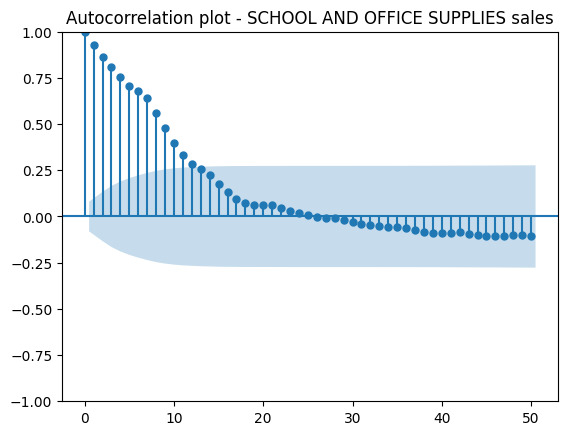

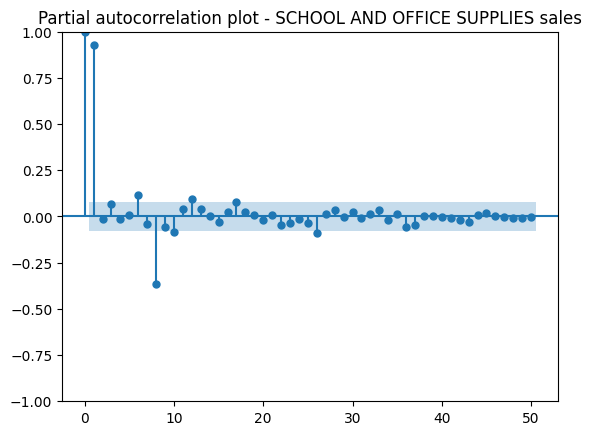

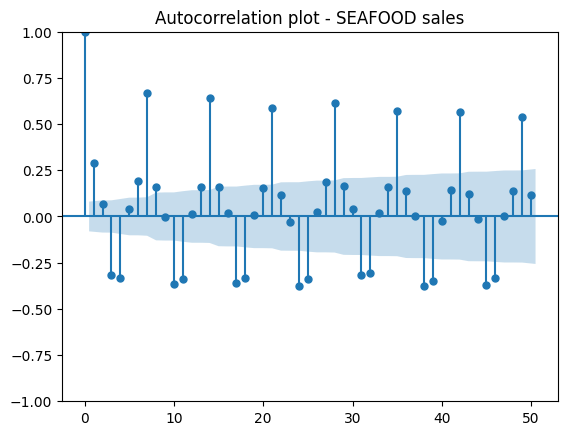

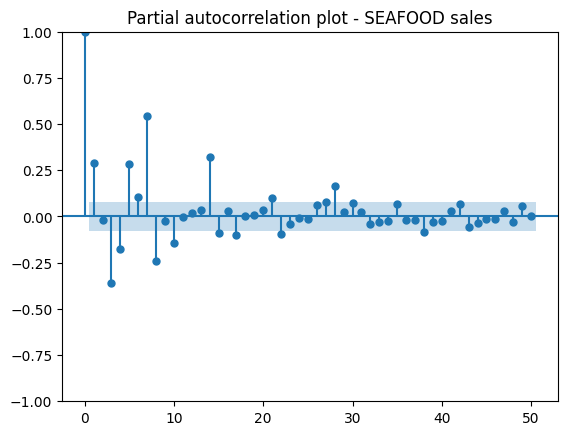

In [9]:
'''
Auto-correlation and particl autocorrelation plots by family.
Below are some of the family of products that have trend and seasonality based on these plots:
    1) Automotive
    3) Beauty
    4) Bread/Bakery
'''
for fam in average_sales_by_family.index.get_level_values('family').unique():
    plot_acf(average_sales_by_family.loc[pd.IndexSlice['2016':'2017', fam], :],lags=50)
    plt.title("Autocorrelation plot - {} sales".format(fam))
    plt.show()
    plot_pacf(average_sales_by_family.loc[pd.IndexSlice['2016':'2017', fam], :],lags=50)
    plt.title("Partial autocorrelation plot - {} sales".format(fam))
    plt.show()
